# **TP - Grupo 4**
Pedro Paulo Costa Pereira - A88062

Tiago André Oliveira Leite - A91693

# **Problema 1 - Sistema de Tráfego**

In [1]:
import networkx as nx
from ortools.linear_solver import pywraplp
from pyscipopt import Model,quicksum,quickprod
import random

### Função para gerar digrafo conexo

In [46]:
def graph_generator(N):
    G = nx.DiGraph()

    nodes = [v for v in range(1,N+1)]
    G.add_nodes_from(nodes)
    random.shuffle(nodes)

    for i in range(len(nodes)-1):
        G.add_edge(nodes[i], nodes[i+1])
    G.add_edge(nodes[len(nodes)-1],nodes[0])

    for n in nodes:
        candidates = [v for v in nodes if v != n]
        random.shuffle(candidates)
        num_adj = random.randint(1,2)
        for i in range(num_adj):
            G.add_edge(n, candidates[i])
    return G

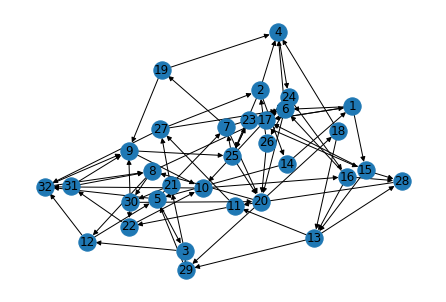

In [47]:
G = graph_generator(32)
nx.draw(G, with_labels = True)

#### Verificar se é conexo 

In [48]:
nx.is_strongly_connected(G)

True

### Função para gerar subdigrafo conexo minimal

In [49]:
def sub_graph_generator(G):
    solver = Model('Trafego')
    
    adj = {}
    for edge in G.edges():
        adj[edge] = solver.addVar(vtype="B",name = '%i%i' %edge)
    
    for s in G.nodes():
        for d in G.nodes():
            if d != s:
                paths = list(nx.all_simple_edge_paths(G, s, d))
                solver.addCons(quicksum([quickprod([adj[(a,b)] for (a,b) in path]) for path in paths]) >= 1)
    
    solver.setObjective(quicksum([adj[edge] for edge in G.edges]), "minimize")
    solver.hideOutput()
    solver.optimize()
    
    S = nx.DiGraph()
    S.add_nodes_from(G.nodes())
    for edge in adj:
        if solver.getVal(adj[edge]) == 1:
            S.add_edge(edge[0],edge[1])
    return S

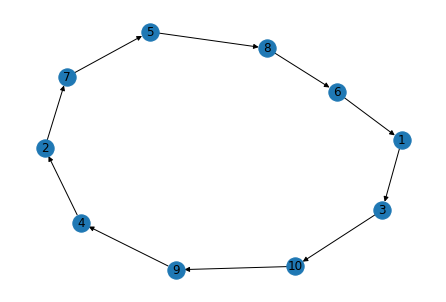

In [14]:
S  = sub_graph_generator(G)
nx.draw(S, with_labels = True)

#### Verificar se é conexo 

In [15]:
nx.is_strongly_connected(S)

True

Solução com pywraplp que nao funciona por causa do all - este solver nao tem quickprod

In [50]:
def sub_graph_generator(G):
    solver = pywraplp.Solver.CreateSolver('SCIP')
    
    adj = {}
    for edge in G.edges():
        adj[edge] = solver.BoolVar('%i%i' %edge)
    
    for s in G.nodes():
        for d in G.nodes():
            if d != s:
                paths = list(nx.all_simple_edge_paths(G, s, d))
                solver.Add(sum([all([adj[(a,b)] for (a,b) in path]) for path in paths]) >= 1)
    
    solver.Minimize(sum([adj[edge] for edge in G.edges]))
    status = solver.Solve()
    if status == pywraplp.Solver.OPTIMAL:
        S = nx.DiGraph()
        S.add_nodes_from(G.nodes())
        for edge in adj:
            if adj[edge].solution_value() == 1:
                S.add_edge(edge[0],edge[1])
        return S
    else:
        print("Sem solução")
                
                
    